# Table of Contents
TODO: update this!
- [Major Classes and File Parsing](#Major-Classes-and-File-Parsing)
- [Load the Data](#Load-the-Data)
- [Signal Exploration](#Signal-Exploration)
- [Classification Experiments](#Classification-Experiments)
- [Visualizing Results](#Visualizing-Results)
- [Sandbox](#Sandbox)

# Overview
This Jupyter Notebook provides you with some basic scaffolding to build and test a model-based classifier like an SVM or decision tree to recognize your gestures. Similar to A3, you will be using similar data structures like SensorData and GestureSet. And, like A3, you will be working with **pre-segmented** data based on how you collected data with the GestureRecorder.

## Misc

### How To Navigate This Notebook
I strongly encourage you to install the [toc2 extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html), which will give you a navigable table of contents (based on markdown) on a side pane and drop-down menu.

### Writing Docstrings
To help with commenting your functions, good to follow best practices with [Docstrings](https://www.python.org/dev/peps/pep-0257/). More [here](https://www.datacamp.com/community/tutorials/docstrings-python).

# Major Classes
These classes have not changed from A3

## SensorData, Trial, GestureSet

In [62]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import signal
import random

class SensorData:
    '''
    Contains the gyroscope, accelerometer, or other sensor data as numpy arrays
    '''
     
    def __init__(self, sensor_type, time, sensor_time, x, y, z):
        '''
        All arguments are numpy arrays except sensor_type, which is a str
        '''
        self.sensor_type = sensor_type
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.time = time.astype(np.int64) # timestamps are in milliseconds
        
        # sensor_time comes from the Arduino function. it's in milliseconds 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensor_time = sensor_time.astype(np.int64) # timestamps are in milliseconds
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sample_length_in_secs = (self.time[-1] - self.time[0]) / 1000.0
        self.sampling_rate = len(self.time) / self.sample_length_in_secs 
        
    def length(self):
        '''
        Returns length (in rows). Note that all primary data structures: time, x, y, z, and mag
        are the same length. So just returns len(self.x). Depending on the preprocessing alg,
        the processed data may be a different length than unprocessed
        '''
        return len(self.x)
        
    def get_data(self):
        '''
        Returns a dict of numpy arrays for each axis of the accel + magnitude
        '''
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    def get_processed_data(self):
        '''
        Returns a dict of numpy arrays for each axis of the accel + magnitude
        '''
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}
    
    
    def preprocess(self, max_array_length = -1):
        '''
        Preprocesses all of the signals (x, y, z, and mag) and stores them in
        self.x_p, self.y_p, self.z_p, and self.mag_p
        '''
        self.x_p = self.__preprocess(self.x, max_array_length)
        self.y_p = self.__preprocess(self.y, max_array_length)
        self.z_p = self.__preprocess(self.z, max_array_length)
        self.mag_p = self.__preprocess(self.mag, max_array_length)
    
        # JonTODO delete this for posting assignment
        # Need to work on this more
        # length_before_trim = len(self.mag_p)
        # self.__trim()
        #print("Trimmed processed signal from {} samples to {}".format(length_before_trim, len(self.mag_p)))
        
    def __trim(self):
        window_start_idx = 0
        last_window_segment = None
        find_start_window_size = 20
        find_end_window_size = 100
        min_max_threshold = 30
        
        window_size = find_start_window_size
        window_step = 10
        new_start_idx = None
        new_end_idx = None
        while window_start_idx + window_size < len(self.mag_p):
            window_segment_mag_p = self.mag_p[window_start_idx : window_start_idx + window_size]
            min_max_diff = abs(np.max(window_segment_mag_p) - np.min(window_segment_mag_p))
            
            if min_max_diff > min_max_threshold:
                if new_start_idx is None:
                    new_start_idx = window_start_idx # start location of event
                    window_size = find_end_window_size
            else:
               new_end_idx = window_start_idx 
                
            window_start_idx += window_step
        
        self.x_p = self.x_p[new_start_idx:new_end_idx]
        self.y_p = self.y_p[new_start_idx:new_end_idx]
        self.z_p = self.z_p[new_start_idx:new_end_idx]
        self.mag_p = self.mag_p[new_start_idx:new_end_idx]
        # JonTODO end delete
    
    def __preprocess(self, raw_signal, max_array_length = -1):
        '''
        Private function to preprocess all of the data
        '''
        # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
        # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
        # Another thing you could explore is to trim the trials so they are as tight as possible
        # around the 'event' itself
  
        # For example, this code smooths the signal using a median filter 
        # https://en.wikipedia.org/wiki/Median_filter#Worked_1D_example
        # Note: a mean filter would work better :)
        
        # Uncomment the following for the assignment
        # med_filter_window_size = 9
        # processed_signal = signal.medfilt(raw_signal, med_filter_window_size)
        # 
        # return processed_signal
        
        
        # *****JonTODO: Delete the following when posting assignment
        # Detrend the signal
        processed_signal = sp.signal.detrend(raw_signal) 
        
        # Smooth the signal with a sliding window average filter
        mean_filter_window_size = 10
        processed_signal = np.convolve(processed_signal, np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                       mode='valid')
        
        # Pad the signal so that they are all the same length
        if max_array_length != -1:
            array_length_diff = max_array_length - len(raw_signal)
            
            # np.pad allows us to pad either the left side, right side, or both sides of an array
            # in this case, we are padding only the right side. 
            # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
            processed_signal = np.pad(processed_signal, (0, array_length_diff), 'mean') 
            
        return processed_signal
        # *****end delete

    def __str__(self):
        return "{}: {} samples {:.2f} secs {:.2f} Hz".format(self.sensor_type, self.length(),
                                                    self.sample_length_in_secs, self.sampling_rate)


class Trial:
    '''
    A trial is one gesture recording and includes an accel SensorData object
    In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
    that may be recorded simultaneously
    '''
    
    def __init__(self, gesture_name, trial_num, log_filename_with_path):
        '''
        We actually parse the sensor log files in the constructor--this is probably bad practice
        But offers a relatively clean solution
        
        gesture_name : the gesture name (as a str)
        trial_num : the trial number (we asked you to collect 5 or maybe 10 trials per gesture)
        log_filename_with_path : the full path to the filename (as a str)
        '''
        self.gesture_name = gesture_name
        self.trial_num = trial_num
        self.log_filename_with_path = log_filename_with_path
        self.log_filename = os.path.basename(log_filename_with_path)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsed_accel_log_data = np.genfromtxt(log_filename_with_path, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsed_accel_log_data)
    
    def get_ground_truth_gesture_name(self):
        '''Returns self.gesture_name'''
        return self.gesture_name
    
    def preprocess(self, max_array_length = -1):
        '''Preprocesses the sensor data'''
        self.accel.preprocess(max_array_length)
        
    def length(self):
        '''Gets the length of the trial in samples'''
        return len(self.accel.x)
    
    def get_start_time(self):
        '''Gets the start timestamp'''
        return self.accel.time[0]
    
    def get_end_time(self):
        '''Gets the end timestamp'''
        return self.accel.time[-1]
    
    def get_end_time_as_string(self):
        '''Utility function that returns the end time as a nice string'''
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.get_end_time() / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gesture_name, self.trial_num, self.log_filename)
        
class GestureSet:
    '''
    Container for a single set of gestures and trials
    '''
    
    def __init__(self, gesture_log_path):
        '''
        After calling the constructor, you must call *load* and then *preprocess*
        
        Parameters:
        gesture_log_path: path to the gesture log dir
        '''
        self.path = gesture_log_path
        self.name = self.get_base_path() # do not change the name, it's used as an dict key
        
    def load(self):
        '''Loads the gesture trials. After calling load, call preprocess'''
        
        # Our primary object tha maps a gesture name to a list of Trial objects
        self.map_gestures_to_trials = self.__parse_gesture_trials(self.path)
     
    def preprocess(self):
        '''Preprocesses the gesture trials'''
        longest_trial_length = self.get_longest_trial().length()
        print("longest_trial_length", longest_trial_length)
        for gesture_name, trials in self.map_gestures_to_trials.items():
            for trial in trials:
                #trial.preprocess(longest_trial_length)
                trial.preprocess()
    
    
    def __parse_gesture_trials(self, path_to_dir):
        '''
        Parses and creates Trial objects for all csv files in the given dir. 
        It's not necessary that you understand this code
        
        Parameters:
        path_to_dir: the path to the gesture logs
        
        Returns:
        dict: a dict() mapping (str: gesture_name) to (list: Trial objects)
        '''
        csv_filenames = find_csv_filenames(path_to_dir)

        print("Found {} csv files in {}".format(len(csv_filenames), path_to_dir))

        map_gesture_name_to_trial_list = dict()
        map_gesture_name_to_map_endtime_to_map_sensor_to_file = dict() # use this to correctly order trials
        for csvFilename in csv_filenames:

            # parse filename into meaningful parts
            # print(csvFilename)
            filename_no_ext = os.path.splitext(csvFilename)[0];

            filename_parts = filename_no_ext.split("_")
            gesture_name = None
            time_ms = None
            num_rows = None
            sensor_name = "Accelerometer" # currently only one sensor but could expand to more

            # Added this conditional because Windows machines created differently formatted
            # filenames from Macs. Windows machines automatically replaced the character "'"
            # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
            # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
            if '__' in filename_no_ext:
                filename_parts1 = filename_no_ext.split("__")
                gesture_name = filename_parts1[0]
                gesture_name = gesture_name.replace('_',"'")
                gesture_name += "'"

                filename_parts2 = filename_parts1[1].split("_")
                time_ms = filename_parts2[0]
                num_rows = filename_parts2[1]
            else:
                filename_parts = filename_no_ext.split("_")
                gesture_name = filename_parts[0]
                time_ms = filename_parts[1]
                num_rows = int(filename_parts[2])

            # print("gesture_name={} time_ms={} num_rows={}".format(gesture_name, time_ms, num_rows))

            if gesture_name not in map_gesture_name_to_map_endtime_to_map_sensor_to_file:
                map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name] = dict()

            if time_ms not in map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name]:
                map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name][time_ms] = dict()

            map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name][time_ms][sensor_name] = csvFilename
            # print (map_gesture_name_to_map_endtime_to_map_sensor_to_file)

        print("Found {} gestures".format(len(map_gesture_name_to_map_endtime_to_map_sensor_to_file)))

        # track the longest array
        max_array_length = -1
        trial_with_most_sensor_events = None

        # Now we need to loop through the data and sort each gesture set by timems values 
        # (so that we have trial 1, 2, 3, etc. in order)
        for gesture_name, map_endtime_to_map_sensor_to_file in map_gesture_name_to_map_endtime_to_map_sensor_to_file.items():
            gesture_trial_num = 0
            map_gesture_name_to_trial_list[gesture_name] = list()
            for end_time_ms in sorted(map_endtime_to_map_sensor_to_file.keys()):
                map_sensor_to_file = map_endtime_to_map_sensor_to_file[end_time_ms]

                log_filename_with_path = os.path.join(path_to_dir, map_sensor_to_file["Accelerometer"])
                gesture_trial = Trial(gesture_name, gesture_trial_num, log_filename_with_path)
                map_gesture_name_to_trial_list[gesture_name].append(gesture_trial)

                if max_array_length < len(gesture_trial.accel.x):
                    max_array_length = len(gesture_trial.accel.x)
                    trial_with_most_sensor_events = gesture_trial

                gesture_trial_num = gesture_trial_num + 1

            print("Found {} trials for '{}'".format(len(map_gesture_name_to_trial_list[gesture_name]), gesture_name))

        # Print out some basic information about our logs
        print("Max trial length across all gesture is '{}' Trial {} with {} sensor events.".
              format(trial_with_most_sensor_events.gesture_name, trial_with_most_sensor_events.trial_num, max_array_length))
        list_samples_per_second = list()
        list_total_sample_time = list()
        for gesture_name, trial_list in map_gesture_name_to_trial_list.items():
            for trial in trial_list: 
                list_samples_per_second.append(trial.accel.sampling_rate)
                list_total_sample_time.append(trial.accel.sample_length_in_secs)

        print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(list_samples_per_second), 
                                                                       sum(list_samples_per_second)/len(list_samples_per_second)))
        print("Avg sample length across {} sensor files: {:0.1f}s".format(len(list_total_sample_time), 
                                                                          sum(list_total_sample_time)/len(list_total_sample_time)))
        print()
        return map_gesture_name_to_trial_list
    
    def get_trials(self, gesture_name):
        '''Returns a list of trials for this gesture name sorted chronologically'''
        return self.map_gestures_to_trials[gesture_name]
    
    def get_all_trials(self):
        '''Gets all trials sorted chronologically'''
        trials = list()
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            trials += trial_list
            
        trials.sort(key=lambda x: x.get_start_time())
        return trials
    
    def get_all_trials_except(self, trial):
        '''Gets all the trials except the given trial'''
        trials = self.get_all_trials()
        trials.remove(trial)
        return trials     
    
    def get_trials_that_overlap(self, start_timestamp, end_timestamp):
        '''Returns the trials that overlap the start and end timestamps (inclusive)'''
        matched_trials = list()
        trials = self.get_all_trials()
        for trial in trials:
            if trial.get_end_time() >= start_timestamp and trial.get_start_time() <= end_timestamp:
                matched_trials.append(trial)
            elif trial.get_start_time() > end_timestamp:
                break # trials are ordered, no need to continue through list
        return matched_trials
    
    def get_longest_trial(self):
        '''Returns the longest trial (based on num rows recorded)'''
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    def get_name(self):
        '''Returns the name'''
        return self.get_base_path()
    
    def get_base_path(self):
        '''Returns the base path of self.path'''
        return os.path.basename(os.path.normpath(self.path))
    
    def get_num_gestures(self):
        '''Returns the number of gestures'''
        return len(self.map_gestures_to_trials)
    
    def get_trials_for_gesture(self, gesture_name):
        '''Returns trials for the given gesture name'''
        return self.map_gestures_to_trials[gesture_name]
    
    # Creates an aggregate signal based on *all* trials for this gesture
    # There are *tons* of methods to create an aggregate signal. This one
    # is super basic: simply tries to align the signals and then takes the mean
    # Note: function currently assumes all trials are the same length
    # Would need to update to handle different sized signals
    # TODO: consider moving this out into a signals part of notebook
    # (to keep GestureSet just as a container class)
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)

                aggregate_signal = trial_signal_mod
            else:

                trial1 = first_trial # used for alignment
                trial2 = trials[i]

                trial1_signal = getattr(trial1.accel, signal_var_name)
                trial2_signal = getattr(trial2.accel, signal_var_name) 
                trial_signals_original.append(trial2_signal)

                trial2_signal_shifted = get_aligned_signal_cutoff_and_pad(trial2_signal, trial1_signal)
                trial_signals.append(trial2_signal_shifted)
                aggregate_signal += trial2_signal_shifted
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    
    def get_min_num_of_trials(self):
        '''
        Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
        different number. We should have the same number of trials across all gestures)
        '''
        min_num_trials = -1 
        for gesture_name, trials in self.map_gestures_to_trials.items():
            if min_num_trials == -1 or min_num_trials > len(trials):
                min_num_trials = len(trials)
        return min_num_trials

    def get_total_num_of_trials(self):
        '''Returns the total number of trials'''
        numTrials = 0 
        for gesture_name, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    def get_random_gesture_name(self):
        '''Returns a random gesture name from within this GestureSet'''
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    def get_random_trial_for_gesture(self, gesture_name):
        '''Returns a random trial for the given gesture name'''
        trials_for_gesture = self.map_gestures_to_trials[gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    def get_random_trial(self):
        '''Returns a random trial'''
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    def get_gesture_names_sorted(self):
        '''Returns a sorted list of gesture names'''
        return sorted(self.map_gestures_to_trials.keys())
    
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), 
                                                                self.get_total_num_of_trials())
           
        

## GestureStream
Used for segmentation

In [63]:
class GestureStream:
    '''
    The primary data structure for the full datastream
    '''
    FULL_DATASTREAM_FILENAME = 'fulldatastream.csv'
    
    def __init__(self, path_to_gesture_log):
        self.path = path_to_gesture_log
        path_to_full_sensor_stream_file = os.path.join(path_to_gesture_log, GestureStream.FULL_DATASTREAM_FILENAME)
        self.filename_with_path = path_to_full_sensor_stream_file
        self.name = self.__get_base_path() # do not change the name, it's used as an dict key
    
    def load(self):
        self.sensor_stream = self.__parse_full_sensor_stream(self.filename_with_path) # SensorData object
    
    def __parse_full_sensor_stream(self, path_to_file):
        
        # fix and verify full sensor stream file
        self.__verify_and_fix_full_sensor_stream(path_to_file)
        
        # parsing 
        parsed_log_data = np.genfromtxt(path_to_file, dtype='str', delimiter=',', 
                                        encoding=None, skip_header=0, 
                                        unpack=True, invalid_raise = False)

        full_sensor_stream = SensorData("Accelerometer", *parsed_log_data)
        return full_sensor_stream
        
    def get_index_closest_to_timestamp(self, timestamp):
        '''
        Returns the closest sensor stream row index closest to timestamp
        '''
        # from https://stackoverflow.com/a/26026189
        idx = np.searchsorted(self.sensor_stream.time, timestamp, side="left")
        return idx
    
    def __verify_and_fix_full_sensor_stream(self, path_to_file):
        '''
        Sometimes the fulldatastream.csv has some small errors in it. This function looks for 
        those errors, ignores those rows, and saves a new 'clean' file without errors
        '''
        import csv
        
        TIME_COL_IDX = 0
        SENSOR_TIME_COL_IDX = 1
        X_IDX = 2
        Y_IDX = 3
        Z_IDX = 4
        MAX_COLUMNS = 5
        
        row_idx = 1
        list_rows = []
        problem_cnt = 0
        
        # The following loop fixes problem lines and removes them
        # For example, in Jesse's log, he has a line (line 4214) that has a *huge* anamalous timestamp:
        # 1571573159855494	8290	337	342	413
        with open(path_to_file) as csvfile:
            csv_reader = csv.reader(csvfile)
            try:
                for row in csv_reader:
                    is_good_row = True
                    
                    if len(row) > MAX_COLUMNS:
                        print("WARNING: Row {} has more than {} columns. The full row:".format(row_idx, MAX_COLUMNS))
                        print(', '.join(row))
                        is_good_row = False
                        problem_cnt += 1
                    
                    col_idx = 0
                    for col in row:
                        stripped_col = col.strip()
                        if not stripped_col: # check for empty str https://stackoverflow.com/a/9573283
                            print("WARNING: Row {} Col {} is empty. The full row:".format(row_idx, col_idx))
                            print(', '.join(row))
                            is_good_row = False
                            problem_cnt += 1
                        col_idx += 1
                            
                    
                    raw_time = int(row[TIME_COL_IDX])
                    sensor_time = int(row[SENSOR_TIME_COL_IDX])
                    x = int(row[X_IDX])
                    y = int(row[Y_IDX])
                    z = int(row[Z_IDX])
                    
                    if is_good_row:
                        list_rows.append(row)
                    
                    row_idx += 1
                
            except Exception as e:
                print("Row {} Error: {}".format(row_idx, e))
                problem_cnt += 1
        
        if problem_cnt > 0:
            import ntpath, os, time
            
            print("File '{}' contained {} lines and {} problems".format(path_to_file, row_idx - 1, problem_cnt))
            path = os.path.dirname(os.path.abspath(path_to_file))
            cur_filename = ntpath.basename(path_to_file)
            cur_filename_without_ext = os.path.splitext(cur_filename)[0]
            new_filename = '{}_old_{}.csv'.format(cur_filename_without_ext, int(round(time.time() * 1000)))
            new_filename_with_path = os.path.join(path, new_filename)
            os.rename(path_to_file, new_filename_with_path)
            print("Renamed problem file to '{}'".format(new_filename_with_path))
            
            with open(path_to_file, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerows(list_rows)
            
            print("Wrote {} 'cleaned' rows to '{}'".format(len(list_rows), path_to_file))
        else:
            print("Successfully checked all {} rows in '{}'. No problems found".format(row_idx-1, path_to_file))
    
    def __get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    def __str__(self):
         return "'{}' : {} rows {:0.1f} secs {:.2f} Hz".format(self.filename_with_path, len(self.sensor_stream.time),
                                                      self.sensor_stream.sample_length_in_secs,
                                                      self.sensor_stream.sampling_rate)
                                                       
class Event:
    '''
    A segmented event in the sensor stream. Similar to a Trial object, contains a
    SensorData object that holds all of the sensor data for this Event
    '''
    def __init__(self, event_idx, sensor_stream, stream_start_idx, stream_end_idx):
        self.event_idx = event_idx
        self.start_idx = stream_start_idx
        self.end_idx = stream_end_idx
        self.start_timestamp = sensor_stream.time[stream_start_idx]
        self.end_timestamp = sensor_stream.time[stream_end_idx]
        self.length_ms = self.end_timestamp - self.start_timestamp
        self.associated_ground_truth_trial = None
           
        # (self, sensor_type, time, sensor_time, x, y, z):
        t = sensor_stream.time[stream_start_idx:stream_end_idx]
        sensor_t = sensor_stream.sensor_time[stream_start_idx:stream_end_idx]
        x = sensor_stream.x[stream_start_idx:stream_end_idx]
        y = sensor_stream.y[stream_start_idx:stream_end_idx]
        z = sensor_stream.z[stream_start_idx:stream_end_idx]
        self.accel = SensorData(sensor_stream.sensor_type, t, sensor_t, x, y, z)
    
    def get_ground_truth_gesture_name(self):
        '''If a ground truth trial has been associated with this Event, return its gesture name'''
        if self.associated_ground_truth_trial == None:
            return 'Null'
        else:
            return self.associated_ground_truth_trial.gesture_name
    
    def length(self):
        '''Gets the length in samples'''
        return len(self.accel.x)
    
    def get_start_time(self):
        '''Gets the start time'''
        return self.accel.time[0]
    
    def get_end_time(self):
        '''Gets the end time'''
        return self.accel.time[-1]
        
    def __str__(self):
        return 'Event #{}: start_idx={} end_idx={} {} ms'.format(self.event_idx,
                                                                         self.start_idx, self.end_idx,
                                                                         self.end_timestamp - self.start_timestamp)

# Utility Functions

## File Handling

In [64]:
# This cell contains some utility functions for file handling parsing
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gesture_name = filename[:tokenSplitPos]
    return gesture_name



## Signal Processing

In [65]:
# Utility Functions: Signal Processing
# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
# TODO: need to write test code that tests this. Use at your own risk
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# Aligns two signals of unequal sizes using cross-correlation. The two signals are then
# trimmed to be equivalent sizes
# For size equalization, the smaller array is first padded
# TODO: need to write test code that tests this. Use at your own risk
def get_aligned_signals_ablate(a, b):
    if len(a) > len(b):
        a_cutoff, b_cutoff = get_aligned_signals_ablate(b, a)
        return (b_cutoff, a_cutoff)
    
    original_a_len = len(a)
    a_padded = a
    
    if len(a) < len(b): # this should always be true unless a == b
        len_diff = len(b) - len(a)
        a_padded = np.pad(a, (0, len_diff), mode='constant', constant_values=0)
        #a_padded = np.pad(a, (0, len_diff), mode='mean') # doesn't work with 'mean'
        
    corr_result_ab = signal.correlate(a_padded,b)
    best_correlation_point = np.argmax(corr_result_ab)
    
    index_shift = len(a_padded) - np.argmax(corr_result_ab) - 1
    index_shift_abs = abs(index_shift)
    #print("best_correlation_point", best_correlation_point, "index_shift", index_shift)
    
    if index_shift >= 0:
        a_shifted = np.pad(a_padded, (index_shift, 0), mode='constant', constant_values=0) # right shift, pad with 0
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))]
        a_cutoff = a_cutoff[index_shift:index_shift + len(a)]
        b_cutoff = b[index_shift:index_shift + len(a)]
    else:
        #print("index less than 0")
        a_shifted = a_padded[index_shift_abs:len(a_padded)] # left shift via ablation
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))] # cut off remaining right side
        b_cutoff = b[0:len(a_cutoff)]
    
    #print("original lengths", len(a), len(b), "cutoff lengths:", len(a_cutoff), len(b_cutoff))
    return (a_cutoff, b_cutoff)

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
# TODO: could also have a mininum height after the zero crossing (withing some window)
# to eliminate noise
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

## GestureSet and GestureStream

In [66]:
# gesture set utility functions

# Gets a random gesture set
def get_random_gesture_set():
    '''
    Returns a random gesture set
    '''
    gesture_set_names = list(map_gesture_sets.keys())
    rand_gesture_set_name = gesture_set_names[random.randint(0, len(gesture_set_names) - 1)]
    return map_gesture_sets[rand_gesture_set_name]

def get_gesture_set(key):
    '''
    Gets the gesture set for the given key
    '''
    return map_gesture_sets[key]

def get_gesture_set_with_str(s):
    '''
    Gets the gesture set containing the str s 
    '''
    for base_path, gesture_set in map_gesture_sets.items():
        if s in base_path:
            return gesture_set
    return None

def get_gesture_stream_with_str(s):
    '''
    Gets the gesture set containing the str s 
    '''
    for base_path, gesture_stream in map_gesture_streams.items():
        if s in base_path:
            return gesture_stream
    return None

def get_gesture_sets_with_str(s):
    '''
    Gets all gesture sets with s in the name
    
    s: can be a string or a collection of strings
    '''
    gesture_sets = []
    for base_path, gesture_set in map_gesture_sets.items():
        if isinstance(s, str):
            if s in base_path:
                gesture_sets.append(gesture_set)
        else:
            for i_str in s:
                if i_str in base_path:
                    gesture_sets.append(gesture_set)
    return gesture_sets

def get_random_gesture_set():
    '''
    Returns a random gesture set
    '''
    import random
    keys = list(map_gesture_sets.keys())
    rand_key = random.choice(keys)
    rand_gesture_set = map_gesture_sets[rand_key]
    return rand_gesture_set

def get_gesture_set_names_sorted():
    '''
    Returns a list of gesture set names sorted by name
    '''
    return sorted(list(map_gesture_sets.keys()))

def get_all_gesture_sets():
    '''
    Gets all of the gesture sets
    '''
    return map_gesture_sets.values() 

# Load the Data

In [67]:
# Load the data
root_gesture_log_path = './GestureLogs'
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
map_gesture_streams = dict()
selected_gesture_set = None
selected_gesture_stream = None
for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    gesture_set.preprocess();
    map_gesture_sets[gesture_set.name] = gesture_set
    
    print("Creating a GestureStream object for path '{}'".format(path_to_gesture_log))
    gesture_stream = GestureStream(path_to_gesture_log)
    gesture_stream.load()
    map_gesture_streams[gesture_stream.name] = gesture_stream
    print("Finished loading:", gesture_stream)

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = get_gesture_set_with_str("Jon")
    selected_gesture_stream = map_gesture_streams[selected_gesture_set.name]

print("The selected gesture set:", selected_gesture_set)
print("The selected gesture stream:", selected_gesture_stream)



['Jesse', 'JonGesturesEasy', 'JonGesturesHarder', 'Stef']
Creating a GestureSet object for path './GestureLogs\Jesse'
Found 55 csv files in ./GestureLogs\Jesse
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Running Man'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Midair Clockwise 'O'' Trial 0 with 310 sensor events.
Avg samples/sec across 55 sensor files: 77.0
Avg sample length across 55 sensor files: 2.5s

longest_trial_length 310
Creating a GestureStream object for path './GestureLogs\Jesse'
Successfully checked all 51619 rows in './GestureLogs\Jesse\fulldatastream.csv'. No problems found
Finished loading: './GestureLogs\Jesse\fulldatas

# Feature Extraction

In [49]:
# Extracts feature vectors

from sklearn import svm
import itertools
import pandas as pd

def extract_features_from_gesture_sets(gesture_sets):
    """Loops through the gesture sets and creates a giant tuple of (features, feature_names)"""
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = []
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
            column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''
    Returns a feature vector for the given trial
    '''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    features.append(trial.accel.mag_p.max())
    feature_names.append("mag_p.max")
    
    features.append(np.std(trial.accel.mag_p))
    feature_names.append("mag_p.std")
    
    features.append(len(trial.accel.mag_p))
    feature_names.append("mag_p.length")
    
    # Some example more "sophisticated" features
    zero_crossings = calc_zero_crossings(trial.accel.mag_p)
    features.append(len(zero_crossings))
    feature_names.append("mag_p.zero_crossings")
    
    min_distance_between_peaks = 77 / 3.0 # 77 is the sampling frequency
    peak_indices, peak_properties = sp.signal.find_peaks(trial.accel.mag_p, height=30, 
                                                         distance=min_distance_between_peaks)
    features.append(len(peak_indices)) 
    feature_names.append("mag_p.peak_count")
    
    # CSE599 TODO:
    # This is where you add in your new features to train the model
    
    return (features, feature_names)



# Feature Exploration

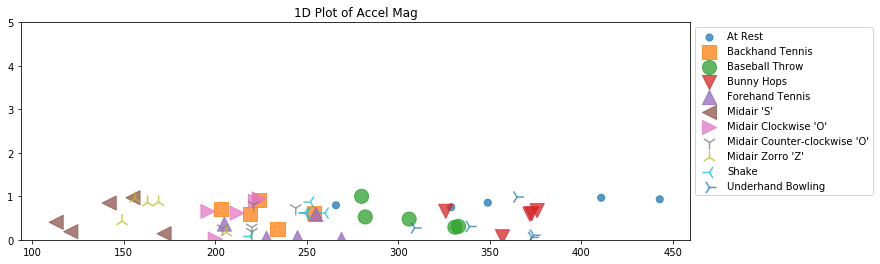

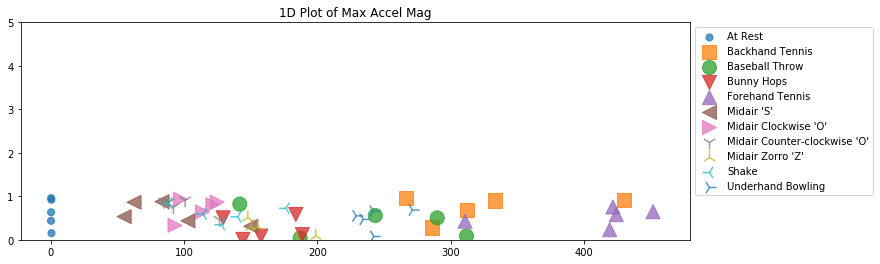

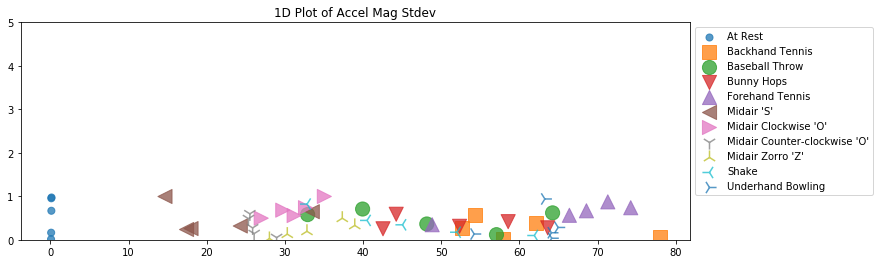

In [9]:
# first, let's graph some features along one dimension
# Brainstorm features
# - Length of signal
# - Max accel magnitude
# - Fundamental frequency
# - Top frequency
# - Intensity of top frequency
# - Top 5 frequency intensities (just plot which bins)
# - Average of values in the signal
# - Std deviation 
# - Count of points above some threshold
# - Counting the number of peaks (above a threshold)
# - Zero crossings 
# - Distance between zero crossings
# - Area under the curve
# - Max frequency of signal
# - Diff between max and mins
# - ... other things... read some papers, brainstorm, visualize!
import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# Plots the length of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list(len(trial.accel.mag) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    # s is the marker size
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Accel Mag")
plt.show()

# Plots the maximum magnitude of each trial's processed acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list(trial.accel.mag_p.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()

# std deviation
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list(np.std(trial.accel.mag_p) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Accel Mag Stdev")
plt.show()

# CSE599 TODO: Come up with ~5 more features to plot below

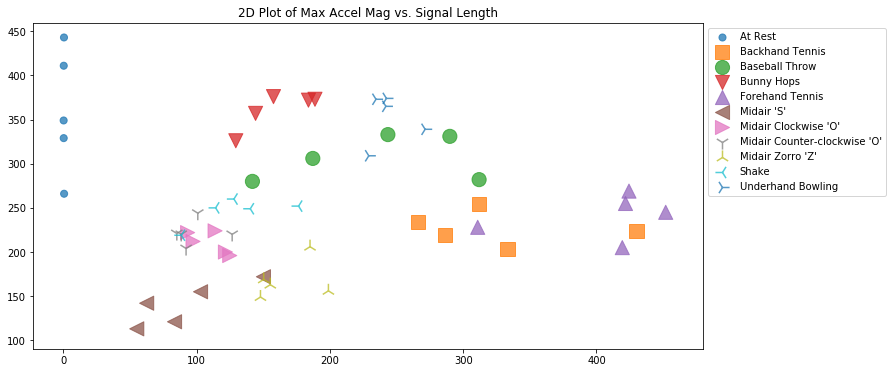

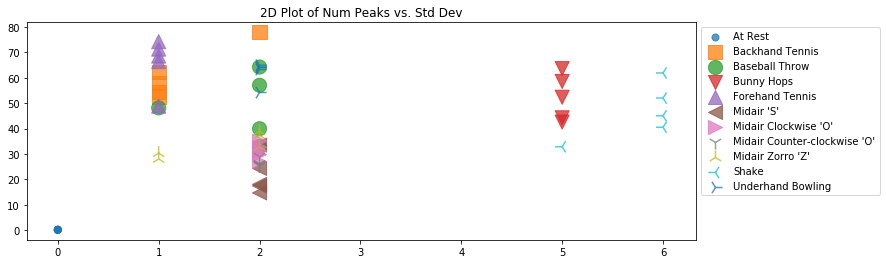

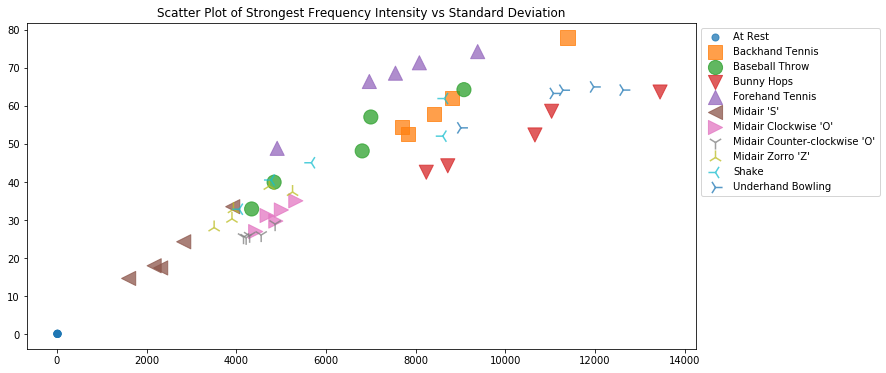

In [10]:
# Now, let's explore the discriminability of 2 dimensions. We should begin to see
# some clusters and visual groupings based on gesture type--that's good!
# And rememember that the SVM is going to be in far more than 2 dimensions... but
# it's harder to visualize anything > 2, so this just gives us some intuition about separation
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list(trial.accel.mag_p.max() for trial in trials)
    y = list(len(trial.accel.mag) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of Max Accel Mag vs. Signal Length")
plt.show()

# num peaks vs. std dev
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = []
    for trial in trials:
        s = trial.accel.mag_p
        min_distance_between_peaks = 77 / 3.0
        peak_indices, peak_properties = sp.signal.find_peaks(s, height=30, distance=min_distance_between_peaks)
        x.append(len(peak_indices))  
        
    y = list(np.std(trial.accel.mag_p) for trial in trials)
    #print(gesture_name, x, y)
    # y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of Num Peaks vs. Std Dev")
plt.show()

# strongest freq intensity vs. std dev
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list(np.abs(np.fft.fft(trial.accel.mag_p)).max() for trial in trials)
    y = list(np.std(trial.accel.mag_p) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)
    
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("Scatter Plot of Strongest Frequency Intensity vs Standard Deviation")
plt.show()

# CSE599 In-Class Exercises TODO: Come up with ~5 more feature relationships to plot below
# Consult gesture recognition research papers for ideas. For example, 
# Wu, J., et al. Gesture recognition with a 3-d accelerometer. UbiComp 2009

## More Advanced Feature Exploration

max freq=3.19 with coef=6.19 for 'At Rest'
max freq=0.53 with coef=8760.72 for 'Backhand Tennis'
max freq=0.35 with coef=6200.25 for 'Baseball Throw'
max freq=1.77 with coef=9011.17 for 'Bunny Hops'
max freq=0.53 with coef=6866.59 for 'Forehand Tennis'
max freq=1.77 with coef=2091.64 for 'Midair 'S''
max freq=1.06 with coef=4853.89 for 'Midair Clockwise 'O''
max freq=1.06 with coef=4190.50 for 'Midair Counter-clockwise 'O''
max freq=0.53 with coef=3920.69 for 'Midair Zorro 'Z''
max freq=5.50 with coef=3853.11 for 'Shake'
max freq=0.35 with coef=10520.97 for 'Underhand Bowling'


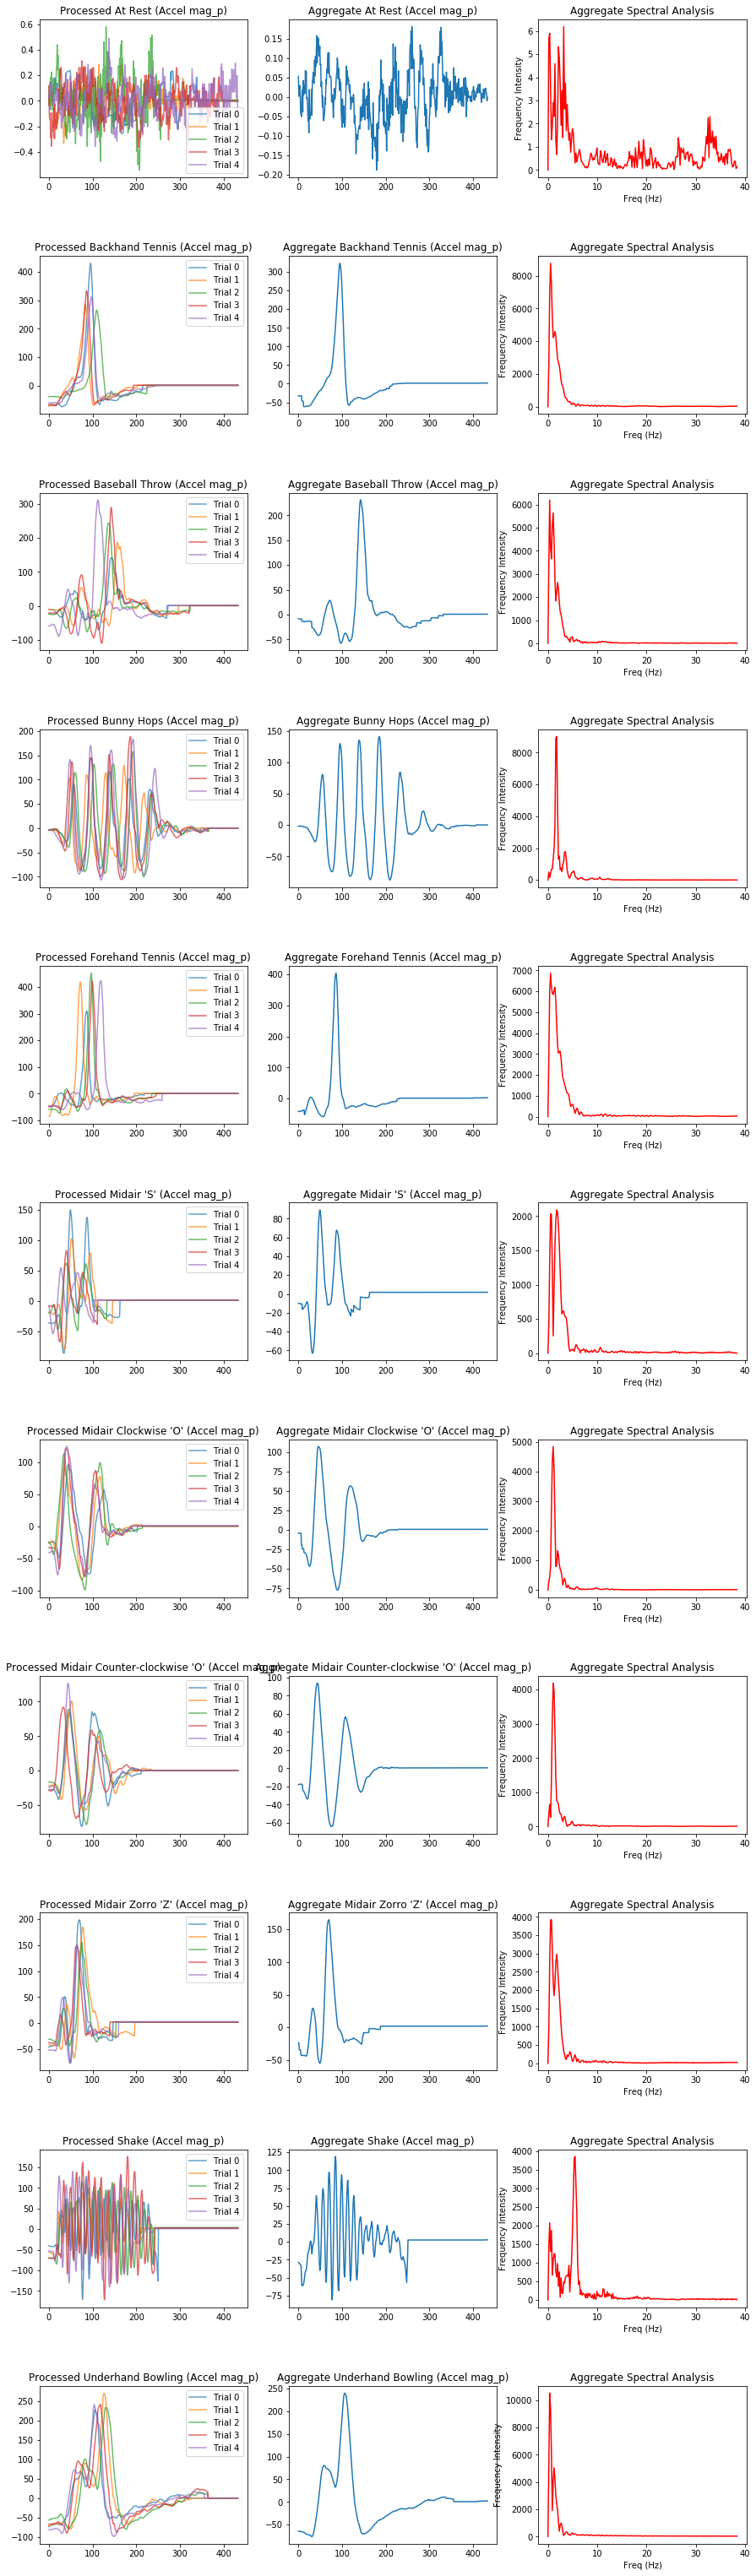

In [11]:
# let's plot the processed mag signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion

num_rows = selected_gesture_set.get_num_gestures()
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

index = 0

signal_var_name = "mag_p"
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.get_trials(gesture_name)
    trialNum = 0
    for trial in trials:
        trial_signal = getattr(trial.accel, signal_var_name)
        axes[index][0].plot(trial_signal, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Processed " + gesture_name + " (Accel {})".format(signal_var_name))
    axes[index][0].legend()
    
    aggregate = selected_gesture_set.create_aggregate_signal(gesture_name, signal_var_name)
    axes[index][1].plot(aggregate, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gesture_name + " (Accel {})".format(signal_var_name))

    # analyze this aggregate signal
    s = aggregate - np.mean(aggregate) # subtract mean to orient around origin
    sampling_rate = 77
    n = len(s)
    fft = np.fft.fft(s)
    freqs = np.fft.fftfreq(n)
    freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

    freqs = freqs[range(n//2)] # one side freq range
    fft = np.abs(fft)[range(n//2)] # one side freq range
    #fft = fft / n # normalize to values 0 - 1
    axes[index][2].plot(freqs, fft, 'r')
    axes[index][2].set_title('Aggregate Spectral Analysis')
    axes[index][2].set_xlabel('Freq (Hz)')
    axes[index][2].set_ylabel('Frequency Intensity')

    # find the max frequency
    # you could modify this to find the top ~3-5 max frequencies
    idx = np.argmax(np.abs(fft))
    max_freq = freqs[idx]
    print("max freq={:0.2f} with coef={:0.2f} for '{}'".format(max_freq, fft[idx],gesture_name))

    index = index + 1

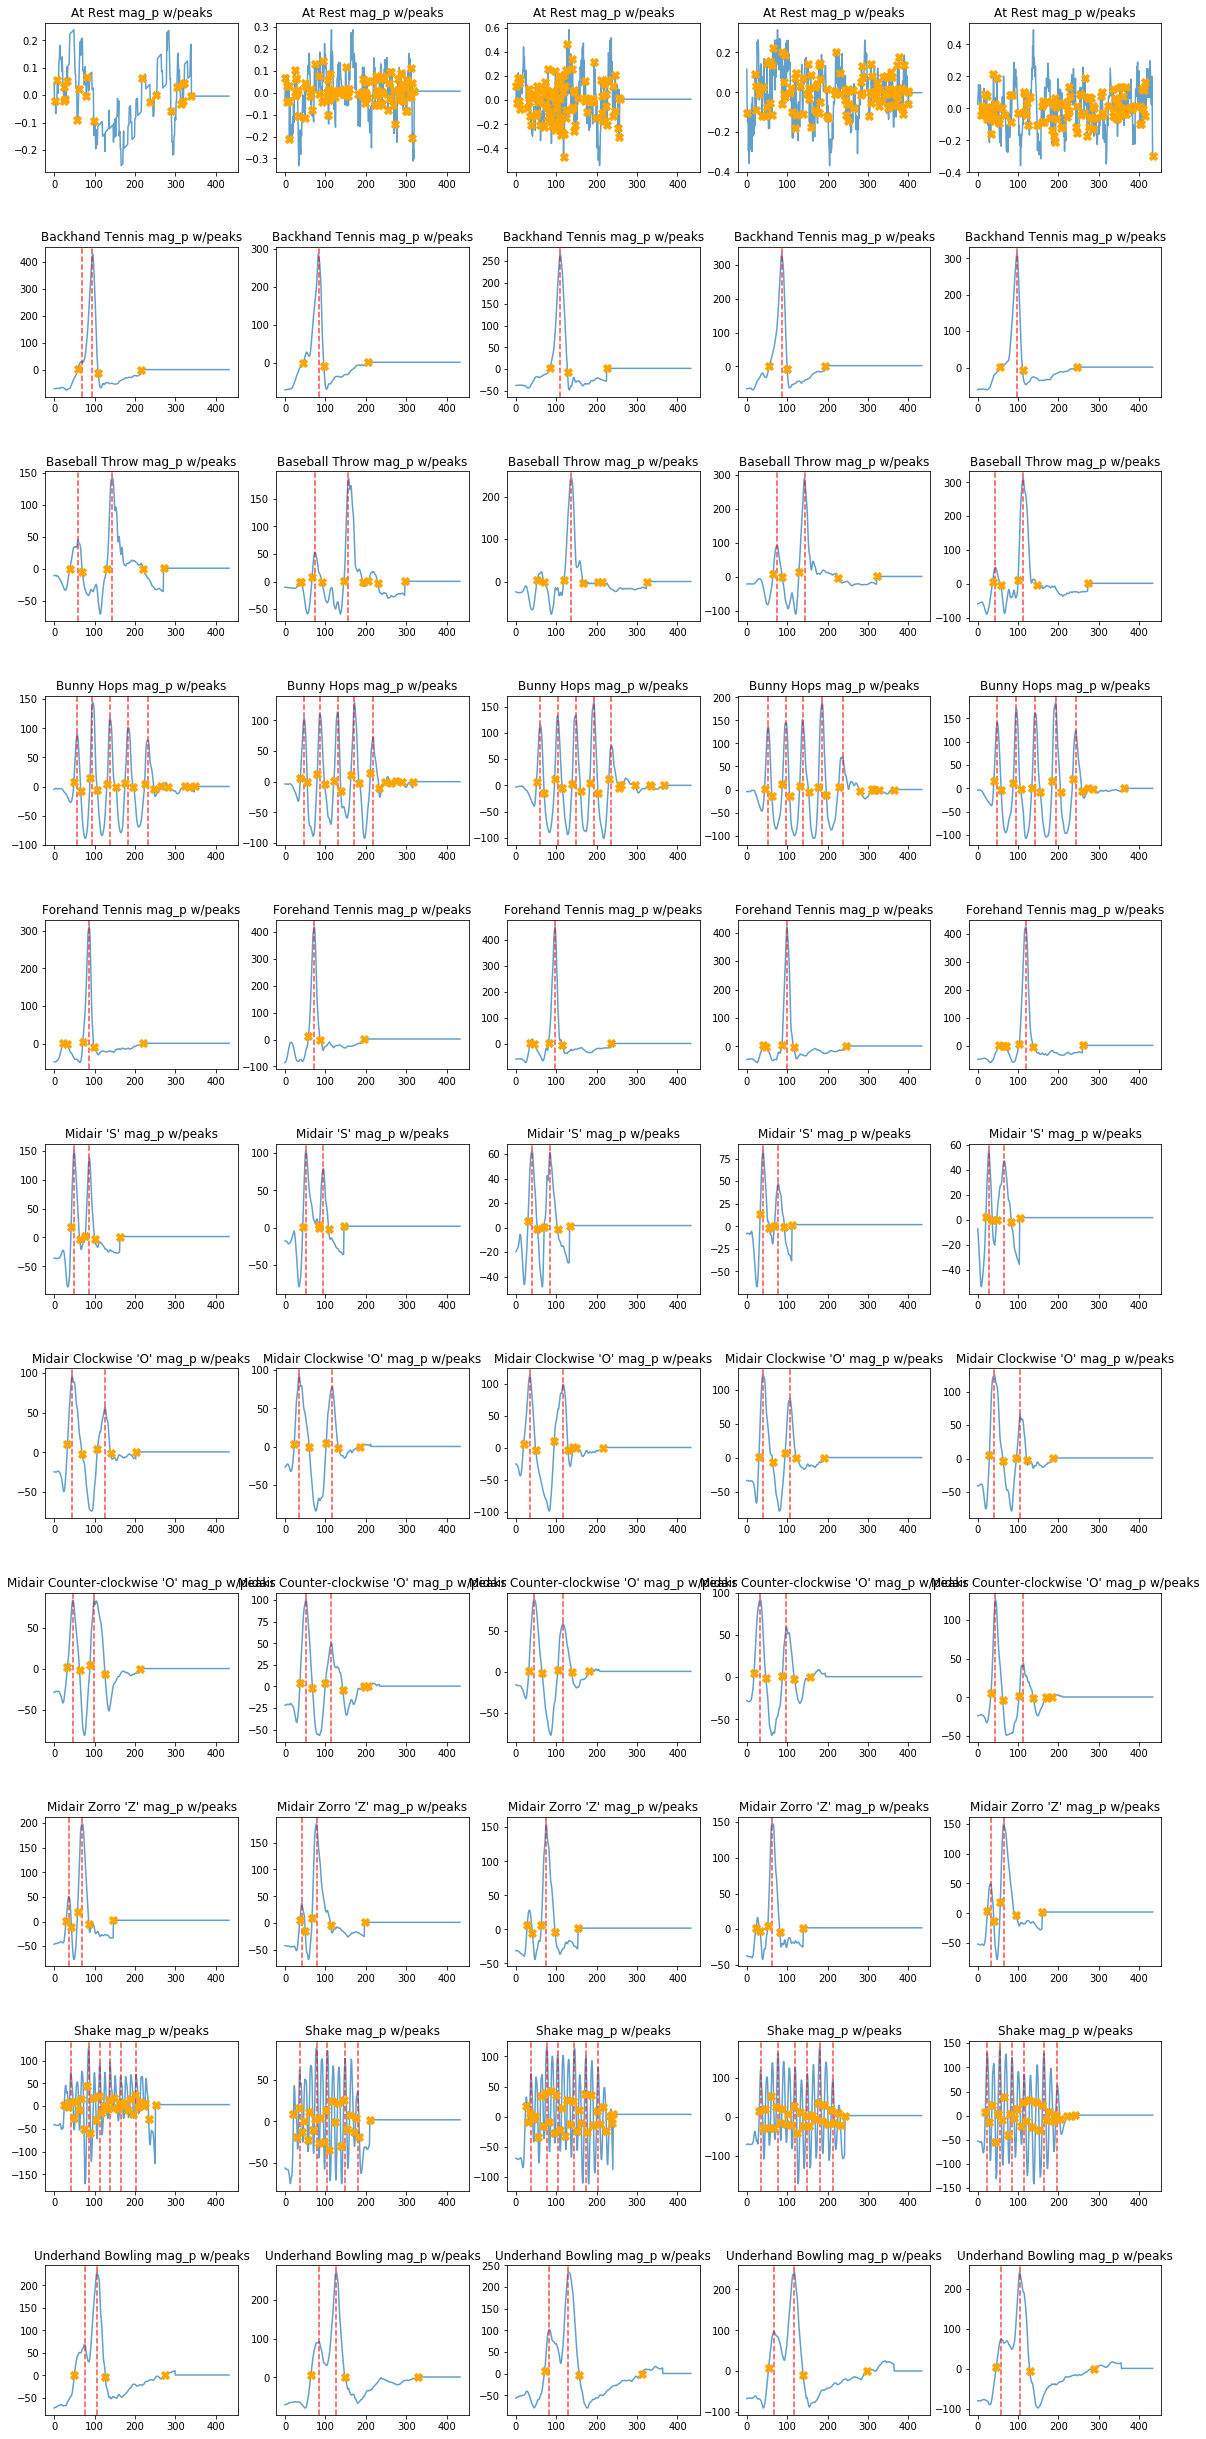

In [14]:
# plot peaks and zero crossings
num_rows = selected_gesture_set.get_num_gestures()
num_cols = 5
row_height = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, row_height * num_rows))
fig.subplots_adjust(hspace=0.5)

row_index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials(gesture_name)
    
    col_index = 0
    for trial in gesture_trials:
        s = trial.accel.mag_p
        axes[row_index][col_index].plot(s, alpha=0.7, label="Trial {}".format(trial.trial_num))
        axes[row_index][col_index].set_title("{} mag_p w/peaks".format(gesture_name))
        
        # our sampling rate is ~77Hz, so distance = 39 is 0.5 seconds
        min_distance_between_peaks = 77 / 3.0
        peak_indices, peak_properties = sp.signal.find_peaks(s, height=30, distance=min_distance_between_peaks)
        #print("peaks", gesture_name, trial.trialNum, len(peak_indices), peak_indices, s[peak_indices])

        for peak_index in peak_indices:
            axes[row_index][col_index].axvline(x=peak_index, color='r', linestyle='--', alpha=0.7)
            
        zero_crossings = calc_zero_crossings(s)
        #print("zero crossings", gesture_name, len(zero_crossings))
        for zero_index in zero_crossings:
            axes[row_index][col_index].plot(zero_index, s[zero_index], marker='X', markersize=8, color="orange")
        
        col_index += 1

    row_index += 1

## Pandas-Based Feature Exploration

In [50]:
import pandas as pd
from pandas.plotting import scatter_matrix

gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# display a full table of our features
display(df)



,mag_p.max,mag_p.std,mag_p.length,mag_p.zero_crossings,mag_p.peak_count,gesturer,gesture,trial_num
0,0.238825,0.117970,340,20,0,JonGesturesEasy,At Rest,0
1,0.286117,0.107286,320,102,0,JonGesturesEasy,At Rest,1
2,0.582405,0.197084,257,104,0,JonGesturesEasy,At Rest,2
3,0.313943,0.128345,402,113,0,JonGesturesEasy,At Rest,3
4,0.491359,0.131536,434,115,0,JonGesturesEasy,At Rest,4
5,430.077423,110.758166,215,2,2,JonGesturesEasy,Backhand Tennis,0
6,286.296327,78.119592,210,3,1,JonGesturesEasy,Backhand Tennis,1
7,266.316107,73.142396,225,2,1,JonGesturesEasy,Backhand Tennis,2
8,333.311404,92.965091,194,2,1,JonGesturesEasy,Backhand Tennis,3
9,312.158363,77.010879,245,2,1,JonGesturesEasy,Backhand Tennis,4


In [51]:
# display a summary table of descriptive stats of our features
display(df.groupby('gesture').describe())

mag_p.max                                     \
                                 count        mean        std         min   
gesture                                                                     
At Rest                            5.0    0.382530   0.147007    0.238825   
Backhand Tennis                    5.0  325.631925  63.669123  266.316107   
Baseball Throw                     5.0  234.919403  70.670247  141.889687   
Bunny Hops                         5.0  160.817156  25.437049  129.416905   
Forehand Tennis                    5.0  405.703669  54.599368  310.909567   
Midair 'S'                         5.0   90.820688  38.067227   55.087921   
Midair Clockwise 'O'               5.0  110.200655  14.244200   93.273359   
Midair Counter-clockwise 'O'       5.0   98.660781  16.732256   85.153224   
Midair Zorro 'Z'                   5.0  167.513522  23.034715  147.918587   
Shake                              5.0  129.530523  32.548612   88.563044   
Underhand Bowling                  5.0  243.937529  16.343904  229.187908   

                                                                              \
                                     25%         50%         75%         max   
gesture                                                                        
At Rest                         0.286117    0.313943    0.491359    0.582405   
Backhand Tennis               286.296327  312.158363  333.311404  430.077423   
Baseball Throw                187.198179  243.532742  290.012557  311.963850   
Bunny Hops                    144.241369  157.691803  183.918612  188.817089   
Forehand Tennis               419.401223  421.812475  424.420342  451.974737   
Midair 'S'                     62.515982   83.434182  102.940144  150.125210   
Midair Clockwise 'O'           97.338474  113.879482  121.643055  124.868907   
Midair Counter-clockwise 'O'   88.465489   92.103386  100.894495  126.687314   
Midair Zorro 'Z'              150.356560  155.287426  185.104321  198.900715   
Shake                         114.271331  128.008298  140.284725  176.525217   
Underhand Bowling             234.595345  242.023782  242.416907  271.463703   

                             mag_p.std             ... mag_p.peak_count       \
                                 count       mean  ...              75%  max   
gesture                                            ...                         
At Rest                            5.0   0.136444  ...              0.0  0.0   
Backhand Tennis                    5.0  86.399225  ...              1.0  2.0   
Baseball Throw                     5.0  58.589891  ...              2.0  2.0   
Bunny Hops                         5.0  57.931380  ...              5.0  5.0   
Forehand Tennis                    5.0  90.326692  ...              1.0  1.0   
Midair 'S'                         5.0  38.686486  ...              2.0  2.0   
Midair Clockwise 'O'               5.0  45.688423  ...              2.0  2.0   
Midair Counter-clockwise 'O'       5.0  37.693069  ...              2.0  2.0   
Midair Zorro 'Z'                   5.0  55.330527  ...              2.0  2.0   
Shake                              5.0  62.733489  ...              6.0  6.0   
Underhand Bowling                  5.0  69.882074  ...              2.0  2.0   

                             trial_num                                          
                                 count mean       std  min  25%  50%  75%  max  
gesture                                                                         
At Rest                            5.0  2.0  1.581139  0.0  1.0  2.0  3.0  4.0  
Backhand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0  4.0  
Baseball Throw                     5.0  2.0  1.581139  0.0  1.0  2.0  3.0  4.0  
Bunny Hops                         5.0  2.0  1.581139  0.0  1.0  2.0  3.0  4.0  
Forehand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0  4.0  
Midair 'S'                         5.0  2.0  1.581139  0.0  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E43D182E8>,
      dtype=object)

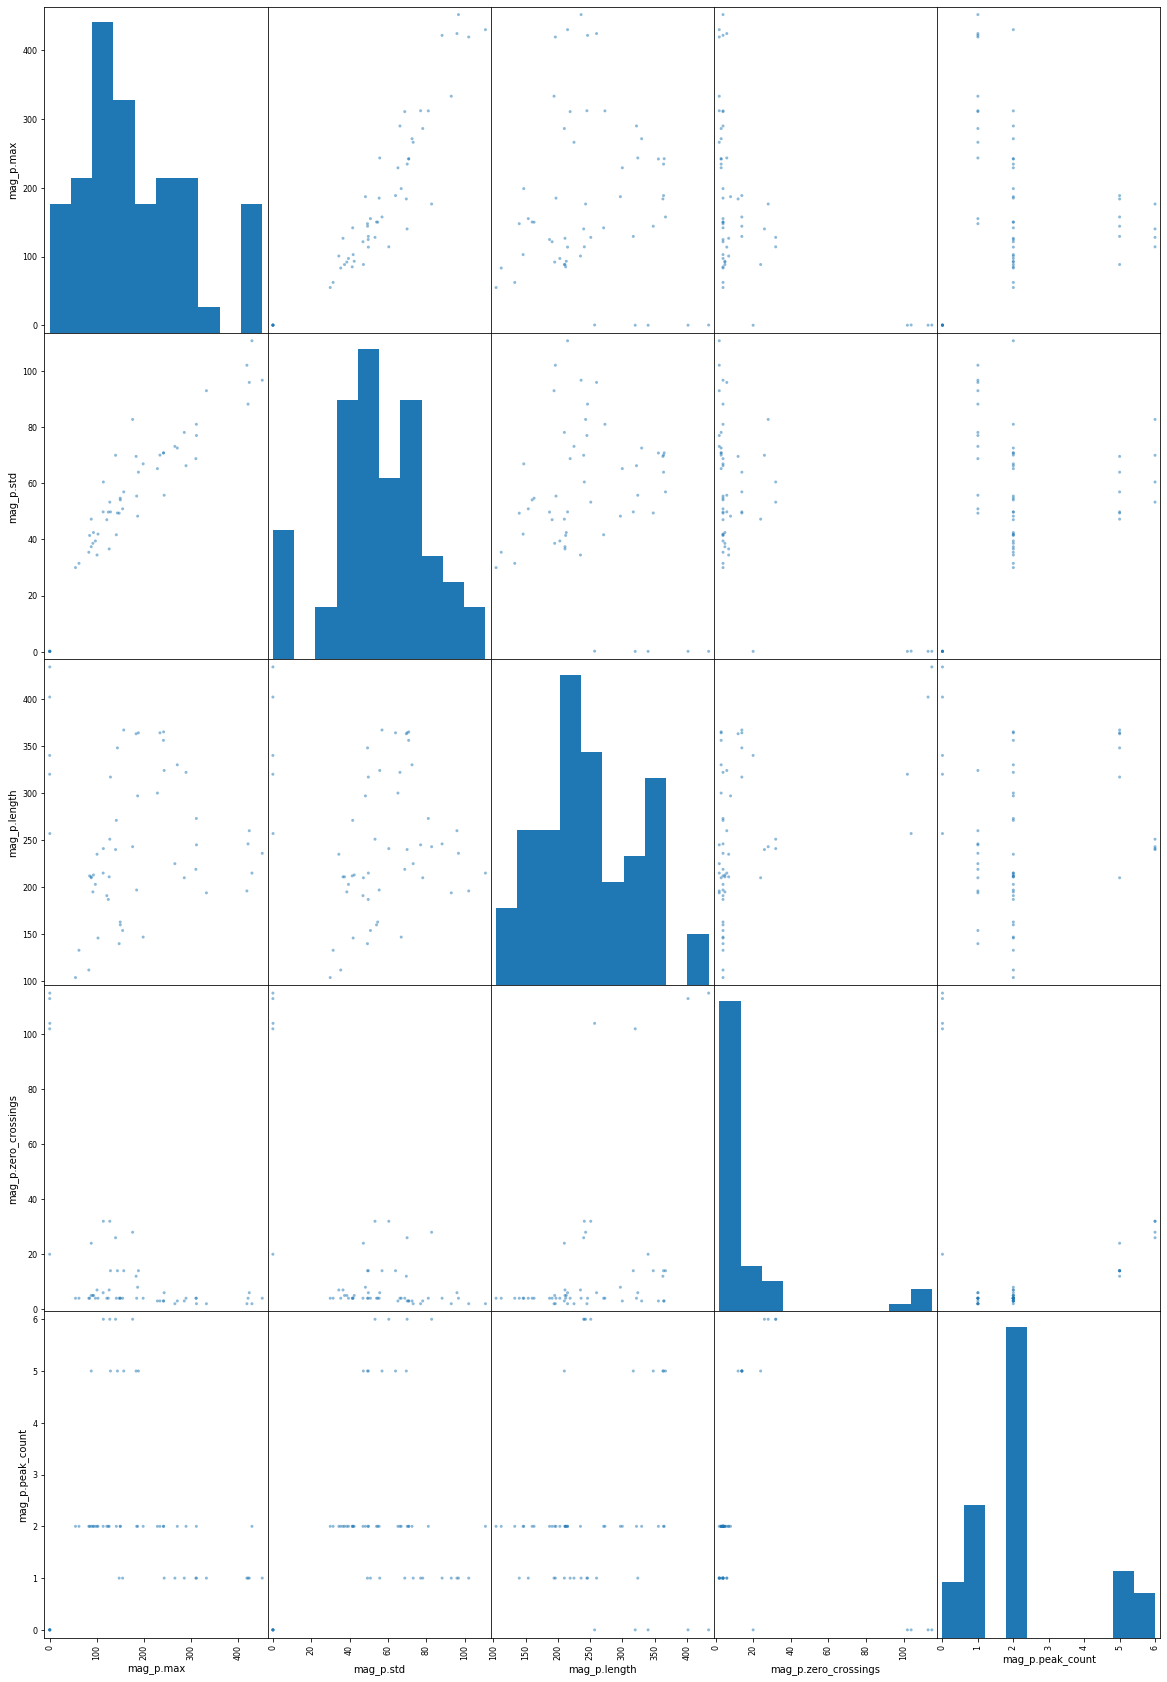

In [52]:
# Plot a scatter matrix of our features
from pandas.plotting import scatter_matrix
gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
df.pop("trial_num")
scatter_matrix(df, figsize=(20,30))

['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'h', 'X']


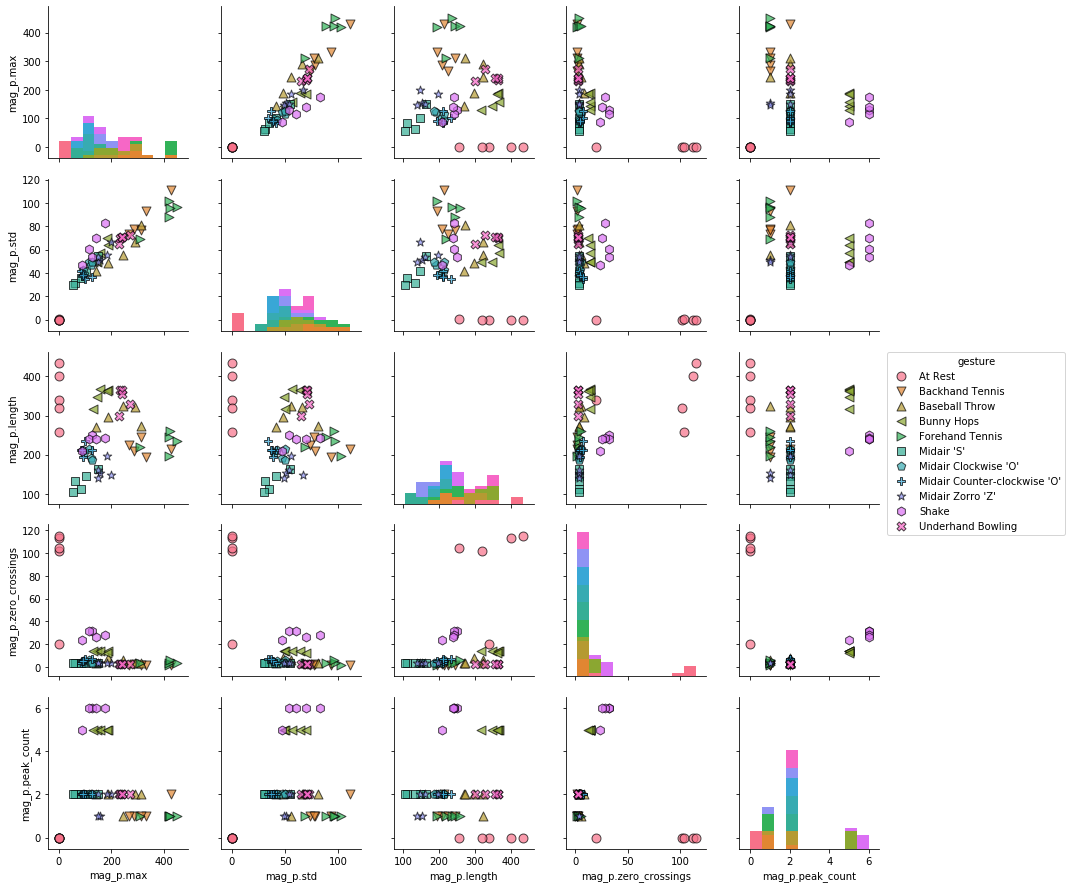

In [53]:
# but seaborn actually has better support for scatter matrices, so let's use that!
import pandas as pd
import seaborn as sns

gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set)
sorted_gesture_names = sorted(gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
df.pop('trial_num') # don't want trial_num in our scatter plot

markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']
markers = markers[:len(selected_gesture_set.map_gestures_to_trials)]
print(markers)

g = sns.pairplot(df, hue="gesture",
                 plot_kws = {'alpha': 0.7, 's': 80, 'edgecolor': 'k'}, 
                 markers = markers)

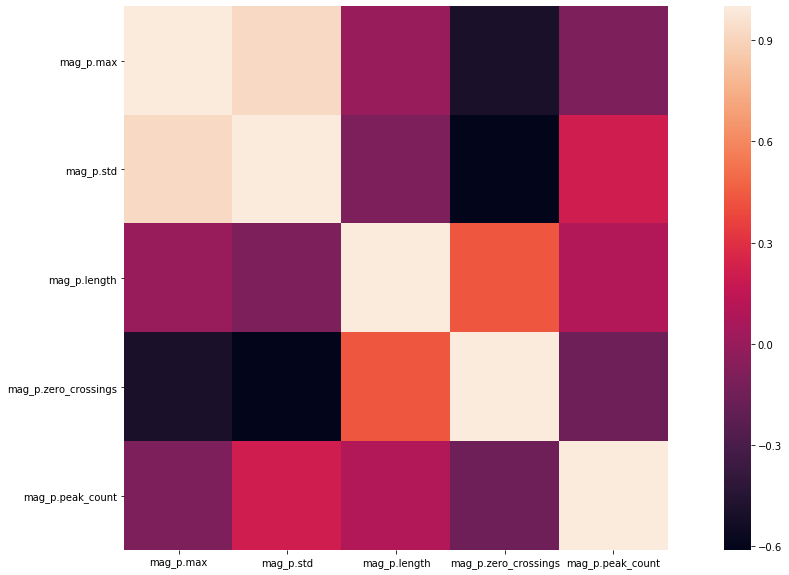

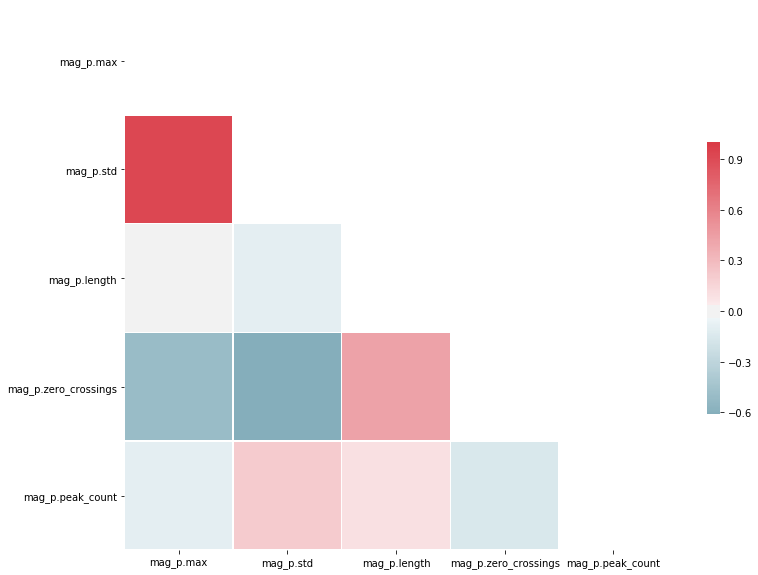

In [54]:
# Plots a cross correlation of the input features. Generally, we want to select features that
# are highly orthogonal (i.e., not correlated). We can use these visualizations to begin looking
# for how features relate to one another

import pandas as pd
import seaborn as sns

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
#display(df)
trial_indices = df.pop("trial_num")
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# Plot the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), square=True)

# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import seaborn as sns
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Classification

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, y=1.02)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
# This is the simplest possible SVM using only a few features but gives you a sense of the overall approach
# Some nice resources:
#  - A very simple classification example using scikit: 
#     https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  - Official sci-kit learn: http://scikit-learn.org/stable/modules/svm.html

# kfold cross validation using cross_val_score
# see: 
# - https://scikit-learn.org/stable/modules/cross_validation.html
# - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture') # our class labels
gesturer = df.pop('gesturer')

kfold_seed = 5 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
scores = cross_val_score(clf, X, y, cv=skf)
print("Fold scores:", scores)
print("Overall: {:.2f}%".format(np.mean(scores)*100))

Fold scores: [0.63636364 0.45454545 0.72727273 1.         0.90909091]
Overall: 74.55%


,fit_time,score_time,test_score
0,0.002970,0.000999,0.636364
1,0.002000,0.000000,0.454545
2,0.001001,0.001002,0.727273
3,0.001998,0.000000,1.000000
4,0.003003,0.000998,0.909091


Overall: 0.7455
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.57      0.80      0.67         5
              Baseball Throw       0.80      0.80      0.80         5
                  Bunny Hops       1.00      1.00      1.00         5
             Forehand Tennis       0.75      0.60      0.67         5
                  Midair 'S'       0.60      0.60      0.60         5
        Midair Clockwise 'O'       0.50      0.80      0.62         5
Midair Counter-clockwise 'O'       0.67      0.40      0.50         5
            Midair Zorro 'Z'       0.60      0.60      0.60         5
                       Shake       1.00      0.80      0.89         5
           Underhand Bowling       1.00      0.80      0.89         5

                 avg / total       0.77      0.75      0.75        55



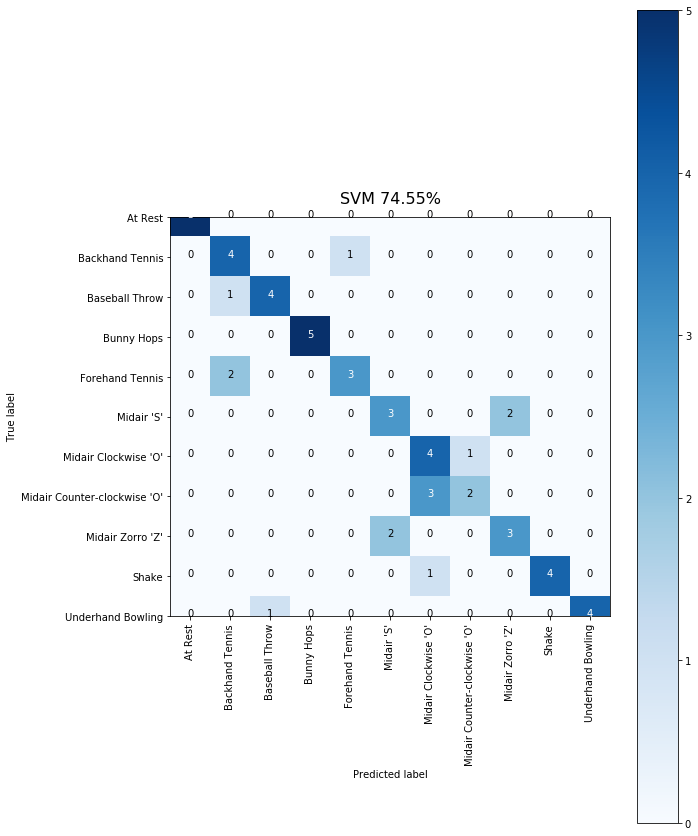

In [59]:
# kfold cross validation using cross_validate and cross_validate_predict rather than cross_val_score
# this allows us to compute different metrics
# see: 
# - https://scikit-learn.org/stable/modules/cross_validation.html
# - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = selected_gesture_set.get_gesture_names_sorted()

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

kfold_seed = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed) #shuffle = False by default
clf = svm.SVC(kernel='linear')
cv_results = cross_validate(clf, X, y, cv=skf, return_train_score=False)
display(pd.DataFrame(cv_results))
print("Overall: {:.4f}".format(np.mean(cv_results['test_score'])))

# we could use cross_val_predict instead to build up a confusion matrix
# see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
np.random.seed(5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
y_pred = cross_val_predict(clf, X, y, cv=skf)
cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,12))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="SVM {:.2f}%".format(accuracy_score(y, y_pred) * 100))
plt.show()

UNSCALED RESULTS: 74.55%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.57      0.80      0.67         5
              Baseball Throw       0.80      0.80      0.80         5
                  Bunny Hops       1.00      1.00      1.00         5
             Forehand Tennis       0.75      0.60      0.67         5
                  Midair 'S'       0.60      0.60      0.60         5
        Midair Clockwise 'O'       0.50      0.80      0.62         5
Midair Counter-clockwise 'O'       0.67      0.40      0.50         5
            Midair Zorro 'Z'       0.60      0.60      0.60         5
                       Shake       1.00      0.80      0.89         5
           Underhand Bowling       1.00      0.80      0.89         5

                 avg / total       0.77      0.75      0.75        55



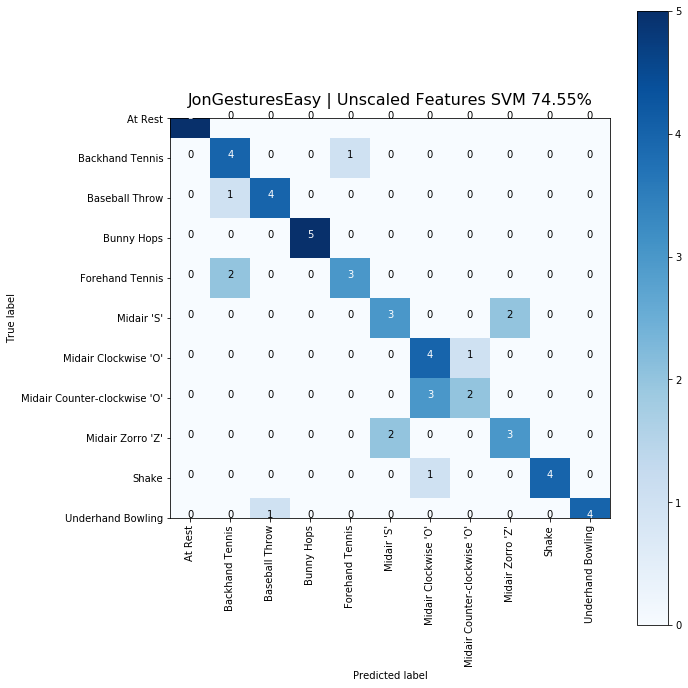

SCALED RESULTS: 80.00%
                              precision    recall  f1-score   support

                     At Rest       1.00      0.80      0.89         5
             Backhand Tennis       0.75      0.60      0.67         5
              Baseball Throw       1.00      0.20      0.33         5
                  Bunny Hops       1.00      1.00      1.00         5
             Forehand Tennis       0.80      0.80      0.80         5
                  Midair 'S'       1.00      0.80      0.89         5
        Midair Clockwise 'O'       1.00      0.60      0.75         5
Midair Counter-clockwise 'O'       0.56      1.00      0.71         5
            Midair Zorro 'Z'       0.71      1.00      0.83         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       0.62      1.00      0.77         5

                 avg / total       0.86      0.80      0.79        55



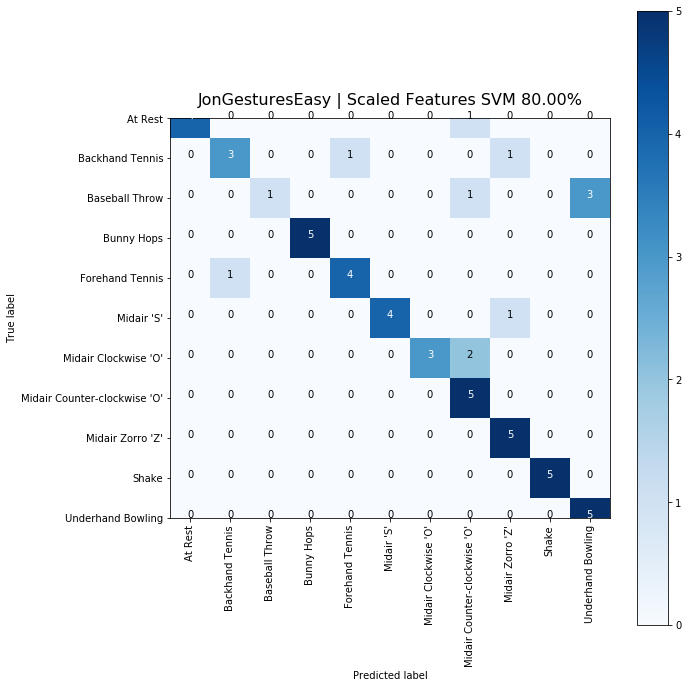

In [72]:
# same as before but with scaling using a pipeline object
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# Unscaled version
np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
y_pred = cross_val_predict(clf, X, y, cv=skf)
print("UNSCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="{} | Unscaled Features SVM {:.2f}%".
                      format(selected_gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
plt.show()

# Scaled version
# Importantly, we can only learn our scaling values based on the training data
# and then apply these both to the training data and the test data
# But how can we do this and still use the nice helper functions like cross_val_predict?
# The answer: pipelines!
np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

clf = svm.SVC(kernel='linear', C=0.1)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="{} | Scaled Features SVM {:.2f}%".
                      format(selected_gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
plt.show()

